In [321]:
import pandas as pd

In [322]:
import cortex

In [323]:
import glob

In [324]:
import re
reg = re.compile('.*/sub-(?P<subject>.+)/ses-(?P<session>.+)/func/sub-(.+)_ses-.+_hemi-(?P<hemi>lh|rh)_energies\.pkl')

In [325]:
fns = glob.glob('/data/odc/derivatives/zmap_spatfreq/sub-*/ses-*/func/sub-*_ses-*_hemi-*_energies.pkl')

In [326]:
fns = fns[1:]

In [327]:
fns

['/data/odc/derivatives/zmap_spatfreq/sub-bm/ses-odc/func/sub-bm_ses-odc_hemi-rh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-de/ses-odc1/func/sub-de_ses-odc1_hemi-lh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-de/ses-odc1/func/sub-de_ses-odc1_hemi-rh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-eo/ses-odc/func/sub-eo_ses-odc_hemi-lh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-eo/ses-odc/func/sub-eo_ses-odc_hemi-rh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-ms/ses-odc2/func/sub-ms_ses-odc2_hemi-lh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-ms/ses-odc2/func/sub-ms_ses-odc2_hemi-rh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-ns/ses-odc/func/sub-ns_ses-odc_hemi-lh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-ns/ses-odc/func/sub-ns_ses-odc_hemi-rh_energies.pkl',
 '/data/odc/derivatives/zmap_spatfreq/sub-tk/ses-odc2/func/sub-tk_ses-odc2_hemi-lh_energies.pkl',
 '/data/odc/derivatives/zmap_s

In [328]:
def get_vertex_mask(subject, hemi='lh', roi='V1'):
    
    
    if hemi == 'lh':
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'l')[roi+hemi[:1]]
    elif hemi == 'rh':
        left_pts, _ = cortex.db.get_surf('odc.{}'.format(subject), hemisphere='left', type='fiducial')
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'r')[roi+hemi[:1]]
        mask -= len(left_pts)
        
    return mask

In [329]:
energies = []
idx = []

for fn in fns:
    e = pd.read_pickle(fn)
    e = e.loc[:,~e.isnull().any(0)]

    meta = reg.match(fn).groupdict()    
    mask = get_vertex_mask(meta['subject'], meta['hemi'])
    
    ix = e.columns.intersection(mask)
    
    e = e.loc[:, ix]    
    print('{}/{} V1 vertices have energy ({}, {})'.format(len(ix), len(mask), meta['subject'], meta['session'], meta['hemi']))
    
    idx.append(meta)
    
    energies.append(e)
    
# energies = pd.concat(energies, axis=0)

2367/4628 V1 vertices have energy (bm, odc)
5536/11046 V1 vertices have energy (de, odc1)
3206/9886 V1 vertices have energy (de, odc1)
3804/9503 V1 vertices have energy (eo, odc)
4987/8879 V1 vertices have energy (eo, odc)
3527/7012 V1 vertices have energy (ms, odc2)
3215/6888 V1 vertices have energy (ms, odc2)
5170/9560 V1 vertices have energy (ns, odc)
3094/9847 V1 vertices have energy (ns, odc)
2946/5771 V1 vertices have energy (tk, odc2)
3552/6746 V1 vertices have energy (tk, odc2)
4777/9629 V1 vertices have energy (tr, odc)
5949/10898 V1 vertices have energy (tr, odc)


In [330]:
energies = pd.concat(energies, 
                     keys=[(d['subject'], d['session'], d['hemi']) for d in idx], 
                     names=['subject', 'session', 'hemi', 'vertex'],
                     axis=1)

In [331]:
energies = energies.drop([('tk', )], axis=1)

In [332]:
max_frequency = energies.groupby(['depth', 'frequency']).sum().groupby('depth', as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax())

In [333]:
max_wl = 1. / max_frequency

In [334]:
import seaborn as sns

In [335]:
import numpy as np

In [388]:
tmp

subject        bm                                                              \
session       odc                                                               
hemi           rh                                                               
vertex     535       536       542       543       544       545       546      
layer                                                                           
6        2.947052  2.947052  2.947052  2.947052  2.811769  2.811769  2.559548   
5        2.947052  2.947052  2.947052  2.947052  2.811769  2.811769  2.682696   
4        3.088844  2.947052  2.947052  2.947052  2.947052  2.811769  2.682696   
3        3.088844  3.088844  3.088844  3.088844  2.947052  2.947052  2.811769   
2        3.088844  3.088844  3.088844  3.088844  3.088844  2.947052  2.947052   
1        3.237458  3.237458  3.088844  3.088844  3.088844  3.088844  2.947052   

subject                                ...        tr                      \
session                                ...       odc                       
hemi                                   ...        rh                       
vertex     554       555       556     ...    28410     28411     28425    
layer                                  ...                                 
6        2.682696  2.682696  1.676833  ...  4.498433  4.498433  4.498433   
5        2.811769  2.682696  1.676833  ...  4.498433  4.498433  4.498433   
4        2.811769  2.811769  1.757511  ...  4.291934  4.291934  4.094915   
3        2.947052  2.947052  1.842070  ...  3.727594  3.906940  3.556480   
2        2.947052  2.947052  1.842070  ...  2.442053  2.329952  2.442053   
1        3.088844  2.947052  2.947052  ...  2.023590  1.930698  2.023590   

subject                                                                        
session                                                                        
hemi                                                                           
vertex     28429     366979    366980    366981    366982    367021    367022  
layer                                                                          
6        1.676833  3.906940  3.906940  3.906940  1.389495  3.237458  2.120951  
5        1.676833  3.906940  4.094915  4.094915  1.842070  3.088844  2.442053  
4        1.599859  4.094915  4.291934  2.811769  2.682696  2.682696  2.442053  
3        1.599859  2.682696  2.682696  2.811769  2.811769  2.442053  2.329952  
2        4.291934  2.947052  2.947052  2.811769  2.811769  2.329952  2.120951  
1        3.906940  2.947052  2.947052  2.811769  2.682696  1.930698  1.930698  

[6 rows x 45632 columns]

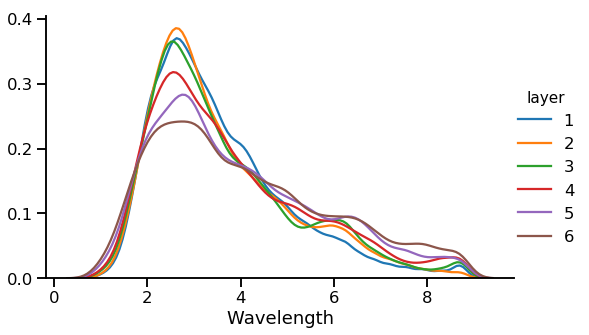

In [402]:
tmp = max_wl.copy()
ix = max_wl.index.tolist()
tmp.index = pd.Index([6 - ix.index(i) for i in ix], name='layer')
tmp = tmp.reset_index().melt(id_vars=tmp.index.names, value_name='Wavelength')
fac = sns.FacetGrid(tmp[tmp.Wavelength < 9], hue='layer', aspect=1.5, height=5)
fac.map(sns.distplot, 'Wavelength', hist=False)
fac.add_legend()

plt.savefig('/data/odc/figures/sf_histogram.pdf', transparent=True)

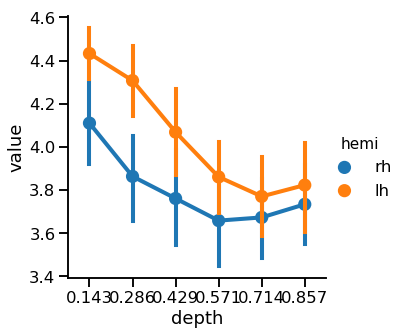

In [337]:
tmp = max_wl.loc[:, (max_wl.mean() < 7)].T.groupby(['subject', 'session', 'hemi'],).mean()
tmp = tmp.reset_index().melt(id_vars=tmp.index.names)
sns.catplot('depth', 'value', hue='hemi', data=tmp, ci=67, kind='point')

In [338]:
sns.set_context('talk')

In [339]:
import matplotlib.pyplot as plt

/Users/gilles/miniconda3/envs/pycortex/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


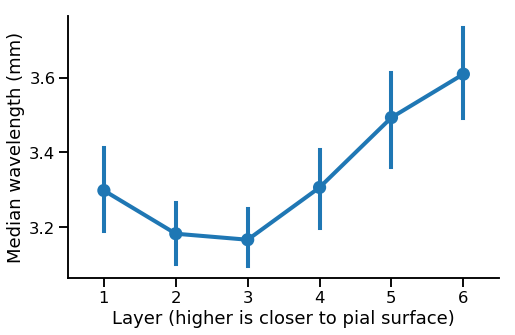

In [343]:
tmp = max_wl.copy()
ix = max_wl.index.tolist()
tmp.index = pd.Index([6 - ix.index(i) for i in ix], name='layer')
tmp = tmp.loc[:, (tmp.mean() < 6)].T.groupby(['subject', 'session', 'hemi'],).median()
tmp = tmp.reset_index().melt(id_vars=tmp.index.names, value_name='Median wavelength (mm)')

tmp['Layer (higher is closer to pial surface)'] = tmp['layer']
sns.catplot('Layer (higher is closer to pial surface)', 'Median wavelength (mm)', data=tmp, ci=67, kind='point', size=5, aspect=1.5)

plt.savefig('/data/odc/figures/sf_depth.pdf', transparent=True)

In [346]:
energies_melted = energies.reset_index().melt(id_vars=energies.index.names)

In [349]:
energies_melted['wavelength'] = 1./energies_melted['frequency']

In [351]:
tmp = energies_melted.groupby(['subject', 'session', 'hemi', 'depth', 'wavelength', 'orientation']).mean().reset_index().pivot_table(index=['depth', 'wavelength'], columns='orientation', values='value')

In [362]:
d

orientation       0.000000  0.196350  0.392699  0.589049  0.785398  0.981748  \
depth wavelength                                                               
0.857 1.000000    0.041561  0.041001  0.040077  0.039257  0.038983  0.039066   
      1.048113    0.044695  0.044053  0.043011  0.042086  0.041764  0.041781   
      1.098541    0.048139  0.047426  0.046235  0.045184  0.044816  0.044722   
      1.151395    0.051887  0.051079  0.049736  0.048543  0.048155  0.047881   
      1.206793    0.055918  0.055000  0.053496  0.052153  0.051439  0.051257   
      1.264855    0.060211  0.059160  0.057499  0.055925  0.055103  0.054806   
      1.325711    0.064702  0.063533  0.061719  0.059929  0.058974  0.058554   
      1.389495    0.069343  0.068062  0.066095  0.064098  0.063031  0.062463   
      1.456348    0.074074  0.072700  0.070612  0.068390  0.067230  0.066491   
      1.526418    0.078805  0.077385  0.075198  0.072649  0.071074  0.070523   
      1.599859    0.083458  0.082034  0.079766  0.076990  0.075236  0.074599   
      1.676833    0.087951  0.086576  0.084267  0.081296  0.079358  0.078623   
      1.757511    0.092180  0.090934  0.088615  0.085409  0.083372  0.082487   
      1.842070    0.096089  0.095025  0.092719  0.089417  0.086919  0.086237   
      1.930698    0.099650  0.098797  0.096568  0.093200  0.090480  0.089787   
      2.023590    0.102842  0.102210  0.100081  0.096654  0.093767  0.093023   
      2.120951    0.105679  0.105271  0.103260  0.099850  0.096633  0.095967   
      2.222996    0.108174  0.107991  0.106105  0.102681  0.099270  0.098544   
      2.329952    0.110363  0.110391  0.108584  0.105101  0.101536  0.100684   
      2.442053    0.112248  0.112441  0.110730  0.107174  0.103397  0.102438   
      2.559548    0.113827  0.114145  0.112497  0.108872  0.104878  0.103768   
      2.682696    0.115075  0.115495  0.113891  0.110202  0.105997  0.104782   
      2.811769    0.115963  0.116479  0.114881  0.111136  0.106760  0.105478   
      2.947052    0.116507  0.117133  0.115506  0.111651  0.107225  0.105982   
      3.088844    0.116687  0.117470  0.115798  0.111801  0.107382  0.106256   
      3.237458    0.116459  0.117495  0.115770  0.111565  0.107278  0.106364   
      3.393222    0.115781  0.117119  0.115393  0.111036  0.106874  0.106268   
      3.556480    0.114621  0.116281  0.114639  0.110175  0.106215  0.105961   
      3.727594    0.112998  0.115035  0.113577  0.108997  0.105219  0.105382   
      3.906940    0.110968  0.113474  0.112231  0.107619  0.104015  0.104536   
      4.094915    0.108612  0.111616  0.110565  0.106020  0.102583  0.103385   
      4.291934    0.105961  0.109394  0.108489  0.104170  0.101061  0.101958   
      4.498433    0.103032  0.106735  0.105981  0.102035  0.099455  0.100377   
      4.714866    0.099929  0.103640  0.103100  0.099661  0.097748  0.098738   
      4.941713    0.096789  0.100249  0.099986  0.097135  0.095888  0.097064   
      5.179475    0.093671  0.096693  0.096760  0.094624  0.093967  0.095277   
      5.428675    0.090663  0.093101  0.093588  0.092223  0.091917  0.093350   
      5.689866    0.087797  0.089815  0.090702  0.089978  0.089784  0.091325   
      5.963623    0.085118  0.087130  0.088301  0.087920  0.087648  0.089257   
      6.250552    0.082608  0.085033  0.086395  0.086060  0.085615  0.087202   
      6.551286    0.080202  0.083337  0.084892  0.084359  0.083664  0.085137   
      6.866488    0.077976  0.081842  0.083639  0.082805  0.081733  0.083037   
      7.196857    0.076097  0.080499  0.082529  0.081302  0.079789  0.080827   
      7.543120    0.074701  0.079310  0.081405  0.079733  0.077836  0.078552   
      7.906043    0.073889  0.078358  0.080236  0.078114  0.075938  0.076234   
      8.286428    0.073617  0.077675  0.079044  0.076494  0.074089  0.074044   
      8.685114    0.073689  0.077222  0.078041  0.075115  0.072612  0.072197   
      9.102982    0.073982  0.076895  0.077287  0.074059  0.071413  0.070863   


<module 'matplotlib.pyplot' from '/Users/gilles/miniconda3/envs/pycortex/lib/python3.7/site-packages/matplotlib/pyplot.py'>

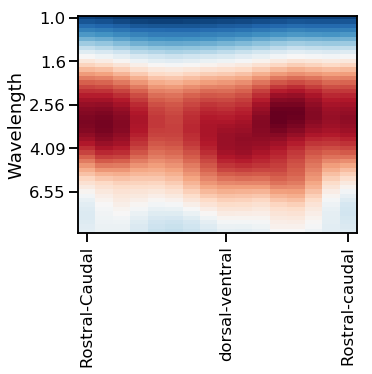

In [379]:
plt.imshow(d, cmap='RdBu_r', aspect=1./4.)

n_wavelengths = 5
rows = np.linspace(0, d.shape[0], 5, endpoint=False, dtype=int)
plt.yticks(rows, np.round(d.index.get_level_values('wavelength')[rows], 2))
plt.ylabel('Wavelength')

plt.xticks([0, d.shape[1] / 2., d.shape[1]-1], ['Rostral-Caudal', 'dorsal-ventral', 'Rostral-caudal'], rotation='vertical')
plt

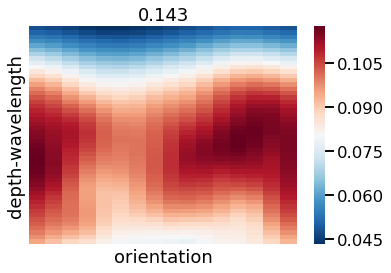

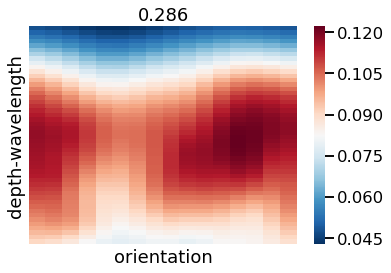

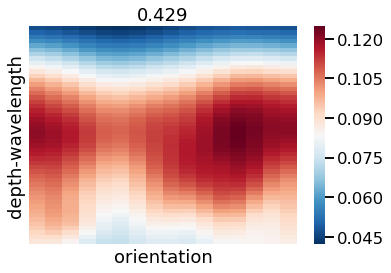

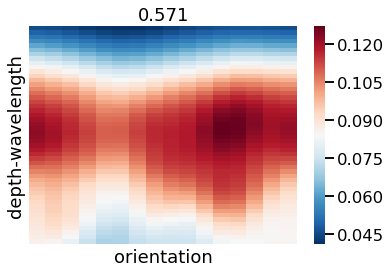

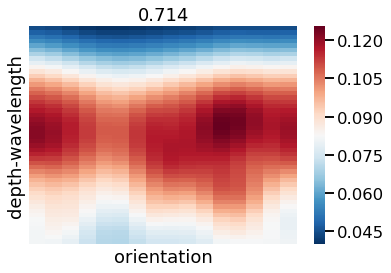

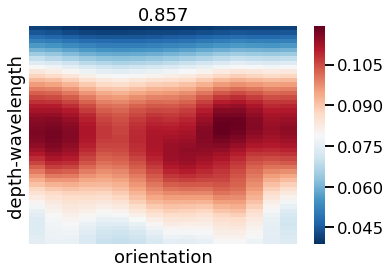

In [353]:
for depth,  d in tmp.groupby(['depth']):
    plt.figure()
    plt.title('{}'.format(depth))
    sns.heatmap(d, cmap='RdBu_r', xticklabels=False, yticklabels=False)